Goal:

* make figure showing how `patience` makes Hyperband scale

Figures to accomplish that:

* num_workers vs time_to_completion
* specific: one random_state, two vertical graphs showing number of workers and num_workers

Show:

1. scaling
2. patience
3. time to accuracy

This means:

* mean accuracy over time (1)
* activity over time for `patience in [True, False]` (in vertical graphs)


* time to accuracy for one set of workers
    * show patience in this graph too
* time to completion for different workers

In [1]:
import pandas as pd

In [2]:
def fname(workers, random_state, patience):
    return f"-workers={workers}-rs={random_state}-patience={patience}"

today = "sim/2019-06-28-"
workers = 16
patience = False
rs = 400
df1 = pd.read_msgpack(today + fname(workers, rs, patience) + "-times.msgpack")
df1["worker_id"] = df1.worker.apply(hash)
print("Unique workers =", len(df1.worker_id.unique()))
df1.iloc[0]

Unique workers = 16


key                   dict-0fc57404-9b2d-4397-8943-281d2d0e21fa
nbytes                                                      240
startstops    ((compute, 1562032388.1779618, 1562032388.1780...
status                                                       OK
thread                                          139720313218816
type          b'\x80\x04\x95\x15\x00\x00\x00\x00\x00\x00\x00...
typename                                          builtins.dict
worker                                tcp://144.92.142.181:4517
worker_id                                  -1323510053318750694
Name: 0, dtype: object

In [3]:
def _get_summary(row):
    out = []
    for x in row.startstops:
        out.append([row.worker_id, row["key"], x[0], x[1], x[2]])
    return out
        

out = df1[["worker_id", "startstops", "key"]].apply(
    _get_summary,
    axis=1
)
print(len(out))
out = list(out)
print(len(out))
out = sum(out, [])
print(len(out))
df = pd.DataFrame(out, columns=["worker_id", "key", "task", "start", "stop"])
df.head()

5450
5450
6162


,worker_id,key,task,start,stop
0,-1323510053318750694,dict-0fc57404-9b2d-4397-8943-281d2d0e21fa,compute,1.562032e+09,1.562032e+09
1,-1323510053318750694,dict-4e48f67c-49cc-48bf-a7df-f8574de65d8e,compute,1.562032e+09,1.562032e+09
2,2184311453528637246,_create_model-b6f65ea6e222f4cc8cdfe7d1ed4a9643,compute,1.562032e+09,1.562032e+09
3,1374620259908538196,_create_model-f5028ea410e6abc663bd967cf2325dbf,compute,1.562032e+09,1.562032e+09
4,-3428832367445544944,_create_model-863fb79e4a0f24d0100f5903e9f9a711,compute,1.562032e+09,1.562032e+09


In [4]:
df["duration"] = df["stop"] - df["start"]

In [5]:
df.groupby("task")["duration"].agg(["min", "mean", "median", "max"])
# df[.head()

,min,mean,median,max
task,,,,
compute,0.000008,1.001693,1.040882,1.261425
transfer,0.002542,0.200571,0.169890,1.008636


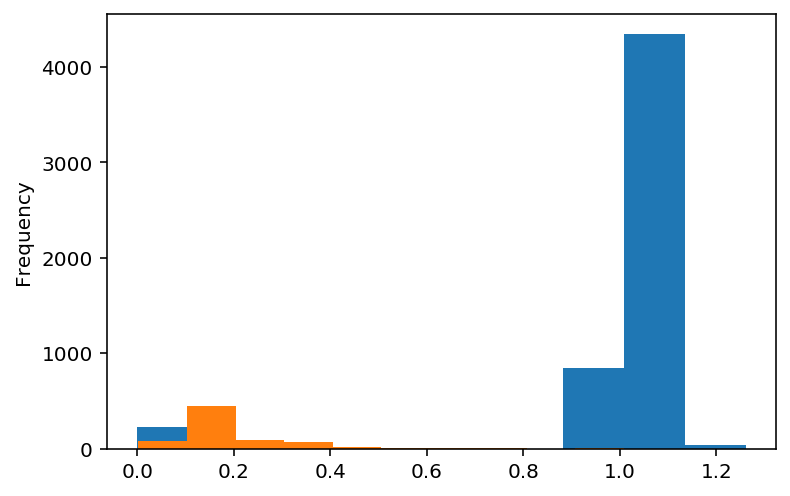

In [6]:
_ = df.groupby("task")["duration"].plot.hist()

In [7]:
show = df[df.task == "compute"]
model_creation = show["key"].apply(lambda x: "_create_model" in x)
start_time = show[model_creation].stop.max()
show = show[show.stop > start_time]

In [8]:
def tasks_running(time, logs):
    task_running = (logs.start < time) & (time < logs.stop)
    return task_running.sum()

In [9]:
import numpy as np
import datetime

times = np.linspace(show.start.min(), show.stop.max(), num=100)
num_workers = [{"time": t, "num_workers": tasks_running(t, show), "datetime": datetime.datetime.fromtimestamp(t)}
               for t in times]

In [10]:
workers = pd.DataFrame(num_workers)
workers["elapsed_time"] = workers.time - workers.time.min()
workers.head()

,datetime,num_workers,time,elapsed_time
0,2019-07-01 20:53:07.706347,0,1.562032e+09,0.000000
1,2019-07-01 20:53:11.985346,16,1.562032e+09,4.278999
2,2019-07-01 20:53:16.264345,16,1.562032e+09,8.557998
3,2019-07-01 20:53:20.543344,16,1.562032e+09,12.836997
4,2019-07-01 20:53:24.822343,16,1.562032e+09,17.115995


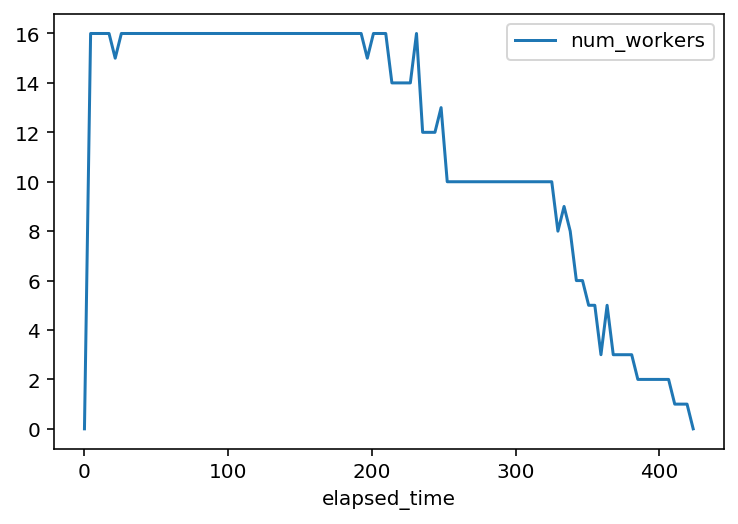

In [11]:
workers.plot(x="elapsed_time", y="num_workers")